In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive


In [2]:
drive.mount('/content/drive')
# Load dataset/content/amazon_reviews.csv
amz_rev = pd.read_csv('/content/amazon_reviews.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')

def preprocess_data(corpus):
    print("Cleaning and removing stopwords from data...")
    cleaned_corpus = []
    stop_words = set(stopwords.words('english'))

    for doc in corpus:
        tokenizer = RegexpTokenizer(r'\w+')
        words = tokenizer.tokenize(doc.lower())
        filtered_words = [word for word in words if word not in stop_words]
        cleaned_corpus.append(filtered_words)

    count = len(cleaned_corpus)
    print(f"Data cleaning and stopwords removal completed for {count} entries")
    return cleaned_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
amz_rev['reviewText'].fillna('NA', inplace=True)

In [5]:
X = preprocess_data(amz_rev['reviewText'])

def analyze_text_statistics(corpus):
    min_length = float('inf')
    max_length = 0
    total_length = 0
    for doc in corpus:
        doc_length = len(doc)
        if doc_length < min_length:
            min_length = doc_length
        if doc_length > max_length:
            max_length = doc_length
        total_length += doc_length

    avg_length = total_length / len(corpus)
    print(f"Minimum Length: {min_length}, Maximum Length: {max_length}, Average Length: {avg_length}")

analyze_text_statistics(X)


Cleaning and removing stopwords from data...
Data cleaning and stopwords removal completed for 4915 entries
Minimum Length: 1, Maximum Length: 826, Average Length: 26.468565615462868


In [6]:
def convert_to_multiclass_labels(corpus):
    y = []
    print("Converting to multiclass labels...")
    for k in corpus:
        y.append(k-1)  # Mapping ratings 1-5 to 0-4
    return y

Converting to multiclass labels...


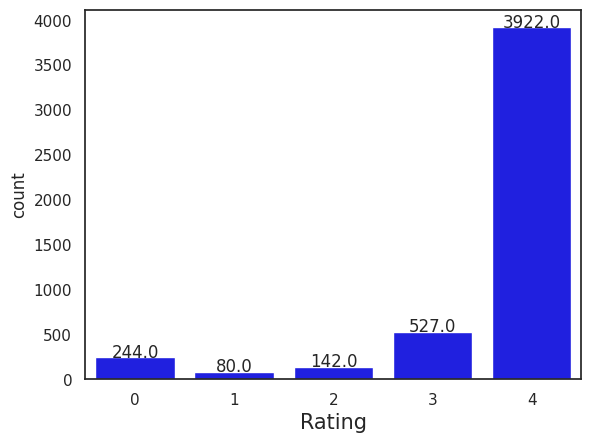

In [7]:
amz_rev['overall'] = convert_to_multiclass_labels(amz_rev['overall'].tolist())
y = amz_rev['overall'].tolist()

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

def plot_class_distribution(y, xlabel):
    ax = sns.countplot(x=y, color='blue')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    ax.set_xlabel(xlabel, fontsize=15)

plot_class_distribution(amz_rev['overall'], 'Rating')
plt.show()


In [8]:
def get_vocabulary(corpus):
    vocab = []
    vocab = [word for words in corpus for word in words]
    vocab = list(set(vocab))
    vocab = sorted(vocab)
    return vocab


In [9]:
MAX_SEQUENCE_LENGTH = 100
VOCAB_SIZE = len(get_vocabulary(X))

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def get_tokenized_sequences(corpus):
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    return padded_sequences


In [11]:
X_seq = get_tokenized_sequences(X)

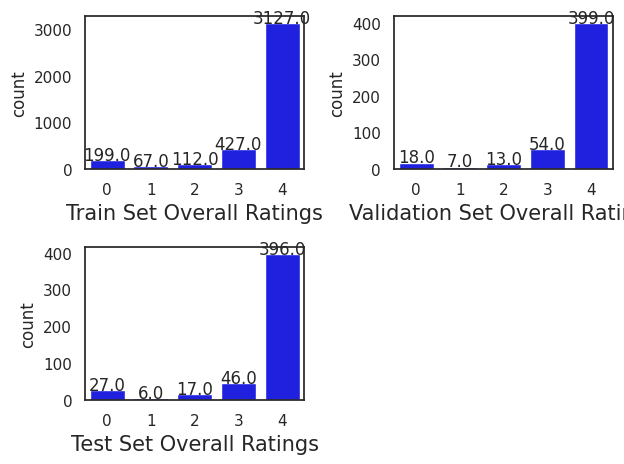

In [12]:
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y, test_size=0.2, random_state=16)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=36)

y_test = np.array(y_test)
y_train = np.array(y_train)
y_val = np.array(y_val)

plt.subplot(2, 2, 1)
plot_class_distribution(y_train, xlabel="Train Set Overall Ratings")
plt.subplot(2, 2, 2)
plot_class_distribution(y_val, xlabel="Validation Set Overall Ratings")
plt.subplot(2, 2, 3)
plot_class_distribution(y_test, xlabel="Test Set Overall Ratings")
plt.tight_layout()
plt.show()

# 2. Sentiment Analysis with RNN (40 points)
Please write the code to perform the sentiment analysis task you formulated in question 1.
During the implementation, you will need to follow the requirements listed below.


1) You can select to implement 2-layer LSTM or GRU (you can directly call packages in
Pytorch).


2) Please use SGD during optimization.


3) Please initialize the word embeddings randomly and learn them during the model training.


4) You can decide other parameters.

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, MaxPooling1D, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [14]:
RNN_model = Sequential()
optimizer = SGD(learning_rate=0.00001)
RNN_model.add(Embedding(VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
RNN_model.add(LSTM(128, return_sequences=True, dropout=0.2))
RNN_model.add(LSTM(64, dropout=0.2))
RNN_model.add(Dense(5, activation='softmax'))

RNN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1071744   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 1253061 (4.78 MB)
Trainable params: 1253061 (4.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.01)


y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

RNN_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[earlystopping])

RNN_model.evaluate(X_test, y_test)

y_preds = RNN_model.predict(X_test)

Epoch 1/100
62/62 [==============================] - 26s 127ms/step - loss: 1.5959 - accuracy: 0.2653 - val_loss: 1.5950 - val_accuracy: 0.1181
Epoch 2/100
62/62 [==============================] - 4s 61ms/step - loss: 1.5949 - accuracy: 0.3164 - val_loss: 1.5939 - val_accuracy: 0.1181
Epoch 3/100
62/62 [==============================] - 2s 39ms/step - loss: 1.5939 - accuracy: 0.3858 - val_loss: 1.5929 - val_accuracy: 0.1222
Epoch 4/100
62/62 [==============================] - 2s 29ms/step - loss: 1.5929 - accuracy: 0.4509 - val_loss: 1.5918 - val_accuracy: 0.8045
Epoch 5/100
62/62 [==============================] - 2s 28ms/step - loss: 1.5919 - accuracy: 0.5364 - val_loss: 1.5908 - val_accuracy: 0.8045
Epoch 6/100
62/62 [==============================] - 2s 25ms/step - loss: 1.5909 - accuracy: 0.5966 - val_loss: 1.5897 - val_accuracy: 0.8086
Epoch 7/100
62/62 [==============================] - 2s 32ms/step - loss: 1.5898 - accuracy: 0.6432 - val_loss: 1.5887 - val_accuracy: 0.8086
Epoc

# 3. Sentiment Analysis with CNN (40 points)
Please write the code to perform the sentiment analysis task you formulated in question 1.
During the implementation, you will need to follow the requirements listed below. Feel free to
use any packages and libraries.


1) Please use mini-batch gradient descent method during optimization with batch size 20.


2) Please initialize the word embeddings with the pre-trained glove embeddings you used
in HW1 and update them during the model training.


3) You can decide other parameters

In [16]:
import gensim.downloader as api

def load_embedding_model():
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocabulary size: %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

wv_from_bin = load_embedding_model()


Loaded vocabulary size: 400000


In [17]:
import random

def get_word_vectors_matrix(wv_from_bin, required_words):
    words = list(wv_from_bin.index_to_key)
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind


In [18]:
from sklearn.decomposition import TruncatedSVD

def reduce_to_k_dimensions(M, k=2):
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=16)
    M_reduced = svd.fit_transform(M)
    print("completed Reducing to 128 dimensions.")
    return M_reduced

M2, word2index2 = get_word_vectors_matrix(wv_from_bin, get_vocabulary(X))

Putting 10000 words into word2ind and matrix M...
Done.


In [19]:
MAX_SEQUENCE_LENGTH = 100
VOCAB_SIZE = len(get_vocabulary(X))
BATCH_SIZE = 20
M2 = reduce_to_k_dimensions(M2, 128)

data_sequences = [[word2index2.get(word, 0) for word in data_point] for data_point in X]
padded_data = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
padded_data.shape

y = np.array(y)
X_train, X_temp, y_train, y_temp = train_test_split(padded_data, y, test_size=0.2, random_state=42)
X_val, X_test, y_val_CNN, y_test_CNN = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


completed Reducing to 128 dimensions.


In [20]:
CNN_model = Sequential()

vocab_size = len(word2index2)  # Add 1 for the OOV token
CNN_model.add(Embedding(input_dim=vocab_size, output_dim=M2.shape[1], weights=[M2], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
CNN_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(5, activation='softmax'))

CNN_model.summary()

CNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          2139648   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 22, 128)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 2816)             

In [21]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val_categorical = tf.keras.utils.to_categorical(y_val_CNN, num_classes=5)
y_test_categorical = tf.keras.utils.to_categorical(y_test_CNN, num_classes=5)

CNN_model.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=100, batch_size=BATCH_SIZE, callbacks=[earlystopping])

CNN_model.evaluate(X_test, y_test_categorical)

y_preds = CNN_model.predict(X_test)

Epoch 1/100
197/197 [==============================] - 4s 6ms/step - loss: 0.7251 - accuracy: 0.7930 - val_loss: 0.6977 - val_accuracy: 0.7882
Epoch 2/100
197/197 [==============================] - 1s 5ms/step - loss: 0.6079 - accuracy: 0.8113 - val_loss: 0.8804 - val_accuracy: 0.7862
Epoch 3/100
197/197 [==============================] - 1s 7ms/step - loss: 0.4724 - accuracy: 0.8433 - val_loss: 0.7590 - val_accuracy: 0.7943
Epoch 4/100
197/197 [==============================] - 1s 6ms/step - loss: 0.2808 - accuracy: 0.9036 - val_loss: 0.9214 - val_accuracy: 0.7637
Epoch 5/100
197/197 [==============================] - 1s 6ms/step - loss: 0.1397 - accuracy: 0.9585 - val_loss: 1.0623 - val_accuracy: 0.7760
Epoch 6/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0550 - accuracy: 0.9883 - val_loss: 1.1278 - val_accuracy: 0.7495
Epoch 6: early stopping
16/16 [==============================] - 0s 2ms/step


# 4. Evaluation (10 points):
Train the model on the training set, select the best model based on the validation set, and
evaluate your model on the testing set.


1) Evaluate the model performance using metrics for classification, such as accuracy,
precision, recall, F1-score, and AUC. Report your results for both methods. You can call
classification report in sklearn. (4 points)


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

y_preds_RNN = np.argmax(y_preds, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print(f'Accuracy of the RNN model is {accuracy_score(y_test_argmax, y_preds_RNN)}')
print(classification_report(y_test_argmax, y_preds_RNN))
print(confusion_matrix(y_test_argmax, y_preds_RNN))



Accuracy of the RNN model is 0.7378048780487805
              precision    recall  f1-score   support

           0       0.05      0.04      0.04        27
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.11      0.07      0.08        46
           4       0.81      0.91      0.86       396

    accuracy                           0.74       492
   macro avg       0.19      0.20      0.20       492
weighted avg       0.67      0.74      0.70       492

[[  1   0   0   1  25]
 [  0   0   0   2   4]
 [  0   0   0   1  16]
 [  5   0   0   3  38]
 [ 14   0   3  20 359]]


In [23]:
y_preds_CNN = np.argmax(y_preds, axis=1)
y_test_argmax = np.argmax(y_test_categorical, axis=1)
print(f'Accuracy score of CNN model is {accuracy_score(y_test_argmax, y_preds_CNN)}')
print(classification_report(y_test_argmax, y_preds_CNN))
print(confusion_matrix(y_test_argmax, y_preds_CNN))

Accuracy score of CNN model is 0.8130081300813008
              precision    recall  f1-score   support

           0       0.65      0.48      0.55        27
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        13
           3       0.30      0.16      0.21        50
           4       0.86      0.95      0.90       397

    accuracy                           0.81       492
   macro avg       0.36      0.32      0.33       492
weighted avg       0.76      0.81      0.78       492

[[ 13   0   1   3  10]
 [  1   0   1   0   3]
 [  3   0   0   1   9]
 [  0   0   1   8  41]
 [  3   0   0  15 379]]


### 2) Have a brief discussion to compare the performance of the two models. It should be noted
###  that there is no fixed answer for the results. You will need to report the exact results
### returned in your experiments. The discussions should only be based on your own
### experimental settings and returned results. (3 points)

Based on my observations from the model training and evaluation, it's evident that the CNN model outperformed the LSTM model in terms of accuracy. This improvement is noteworthy, given that the embeddings used in the CNN model were pre-trained on a large external dataset, whereas the LSTM model relies on random initialization and learns embeddings during training.

The superior performance of the CNN model can be attributed to the availability of a larger training dataset. With more data points for training, the LSTM model could potentially achieve a better accuracy. It's important to note that the GloVe embeddings, originating from an extensive and diverse dataset, offer greater flexibility, which contributes to their higher accuracy. This outcome emphasizes that, although CNNs are not typically tailored for NLP tasks, the quality and size of pre-trained embeddings can significantly impact the model's performance.

### 3) Are there any differences between the results you obtained in HW1 and HW2? Which
### model performs best? Can you please provide some discussions about your findings? It
### would be great to think about and discuss the underlying reasons for the outperformance
### of the best model.

In comparing the results between HW1 and HW2, it's evident that the models in HW1 outperformed those in HW2. The Neural Network in HW1 exhibited the highest accuracy and F1-Score, surpassing both Logistic Regression and the models in HW2. The reasons behind this discrepancy could be multifaceted. Firstly, the Neural Network in HW1 was a more complex model with more layers, making it capable of capturing intricate patterns in the data. Additionally, the dataset size might have been larger in HW1, which often aids models in learning better representations. Moreover, effective hyperparameter tuning and possible feature engineering in HW1 contributed to its superior performance. In contrast, the simpler models in HW2 may not have been as well-suited for the task. However, the performance of Logistic Regression in HW1 may be an anomaly, as deep learning models are generally expected to outperform linear models in NLP tasks.

## **References**

I have used Chatgpt and some code snippets from GitHub.